In [3]:
from sae_lens import HookedSAETransformer, SAE, SAEConfig
from gemma_utils import get_gemma_2_config, gemma_2_sae_loader


In [2]:
import numpy as np
import torch
import tqdm
import einops
import re
from jaxtyping import Int, Float
from typing import List, Optional, Any
from torch import Tensor
import json
import os
from torch.utils.data import Dataset, DataLoader
import random
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from transformer_lens.utils import get_act_name

In [4]:
np.random.seed(0)
random.seed(0)
torch.random.manual_seed(0)

### Get the model

In [5]:
model = HookedSAETransformer.from_pretrained("google/gemma-2-2b-it")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b-it into HookedTransformer


In [5]:
x = torch.arange(0,300)


## Get the dataset

In [6]:
from datasets import load_dataset

ds = load_dataset("santhoshmlops/Skai_Gemma_Instruct_ChatTemplate",split = "train")
text = ds[:1000]['text']
tokenized_ds = model.tokenizer(text, return_tensors = "pt", padding = True)
pairs_length = tokenized_ds['attention_mask'].sum(dim = -1).numpy()
indices = torch.where(torch.tensor(np.logical_and(pairs_length>50, pairs_length<200)))
text_array = np.array(text)[indices]
samp_ind = torch.randperm(len(text_array))[:300]
final_text = text_array[samp_ind].tolist()
tokens = model.tokenizer(final_text, return_tensors = "pt", padding = True, )


<Axes: ylabel='Count'>

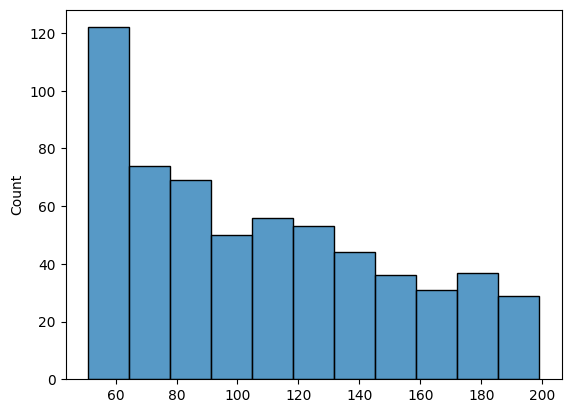

In [7]:
sns.histplot(tokens['attention_mask'].sum(dim = -1).numpy())

In [8]:
len(torch.where(tokens['input_ids']==106)[0])# checks out 2 turns for each datapoint

1202

In [7]:
starts_model_turn_pos = torch.stack([torch.where(tok == 106)[0][-1] for tok in tokens["input_ids"]])# get the second turn

<Axes: ylabel='Count'>

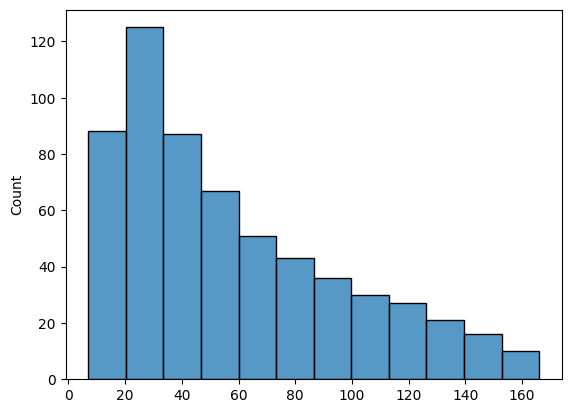

In [10]:
sns.histplot(tokens['attention_mask'].sum(dim = -1)-starts_model_turn_pos)

In [8]:
from functools import partial
tokens = model.to_tokens(final_text,prepend_bos = False)
def caching_hook(activations, hook, pos = None):
    cache[hook.name] = activations.to("cpu")[:,pos+1,:]

all_acts = {}
for i,t in tqdm.tqdm(enumerate(tokens)):
    pos = starts_model_turn_pos[i]
    hook_fn = partial(caching_hook, pos = pos)
    cache = {}
    with model.hooks(fwd_hooks=[(get_act_name("pre",i),hook_fn) for i in range(0,model.cfg.n_layers)]),torch.no_grad():  
        _ = model(t)
        all_acts[f"Query {i}"] = cache


acts = torch.stack([torch.stack([v for k,v in val.items()])for key,val in all_acts.items()])
tokens = model.tokenizer(final_text, return_tensors = "pt", padding = True, )
lengths = (tokens['attention_mask'].sum(dim = -1)-starts_model_turn_pos).tolist()
lengths = torch.tensor(lengths, dtype=torch.float32)

300it [01:42,  2.92it/s]


In [30]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

def train_classification_probe(act, target, test_size=0.2, l1_lambda=0.01, num_epochs=20, top_k=10, n_bins=4):


    # Discretize the target into bins
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    target_binned = est.fit_transform(target.reshape(-1, 1)).squeeze().astype(int)
    target_binned = torch.tensor(target_binned, dtype=torch.long)  # Convert to tensor of longs

    # Split the data into train and test sets
    train_activations, test_activations, train_labels, test_labels = train_test_split(
        act, target_binned, test_size=test_size, random_state=42
    )

    # Ensure that train_labels and test_labels are 1D tensors
    train_labels = train_labels.squeeze()  # Ensure shape [batch_size]
    test_labels = test_labels.squeeze()    # Ensure shape [batch_size]

    # Define a linear classification probe with L1 regularization
    class ClassificationProbe(nn.Module):
        def __init__(self, input_size, n_classes):
            super(ClassificationProbe, self).__init__()
            self.fc = nn.Linear(input_size, n_classes)  # Output logits for each class
        
        def forward(self, x):
            return self.fc(x)

    probe = ClassificationProbe(input_size=act.size(-1), n_classes=n_bins)

    # Define the loss function and optimizer with L1 regularization
    criterion = nn.CrossEntropyLoss()  # Cross-Entropy loss for classification
    optimizer = torch.optim.Adam(probe.parameters(), lr=1e-3)

    # Training loop
    for epoch in range(num_epochs):
        probe.train()
        
        optimizer.zero_grad()
        predictions = probe(train_activations)
        
        # Compute the loss with L1 regularization
        l1_norm = sum(p.abs().sum() for p in probe.parameters())
        loss = criterion(predictions, train_labels) + l1_lambda * l1_norm
        
        loss.backward()
        optimizer.step()
        
        # Print the loss for monitoring
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the probe on the test set
    probe.eval()
    with torch.no_grad():
        test_predictions = probe(test_activations)
        test_loss = criterion(test_predictions, test_labels)

        # Calculate accuracy
        _, predicted_labels = torch.max(test_predictions, 1)
        accuracy = (predicted_labels == test_labels).float().mean()
        print(f'Test Loss: {test_loss.item():.4f}')
        print(f'Test Accuracy: {accuracy.item() * 100:.2f}%')

    # After training, analyze the weights of the probe to find the top-k important features
    weights = probe.fc.weight.data.abs()  # Take the absolute value of weights
    top_k_indices = weights.topk(k=top_k, dim=-1).indices  # Get the indices of top-k weights

    print(f"Top-{top_k} important activations indices: {top_k_indices}")

    return top_k_indices, accuracy.item()

In [31]:
all_test_losses = []
for i in range(model.cfg.n_layers):
    act = acts[:,i,:,:]
    k_idx, test_loss = train_classification_probe(act,lengths)
    all_test_losses.append(test_loss)


RuntimeError: Expected target size [240, 4], got [240]

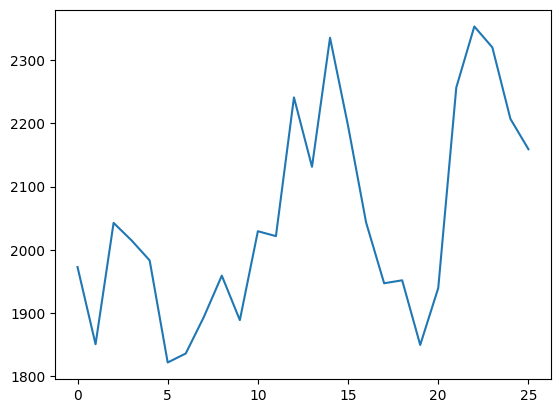

In [11]:
sns.lineplot(all_test_losses)
plt.show()

In [32]:
_,cache = model.run_with_cache("the")

In [53]:
import einops

In [139]:
tokens = model.to_tokens(final_text[0], prepend_bos = False)
def caching_hook(activations, hook, pos = None):
    cache[hook.name] = activations.to("cpu")

hook_fn = partial(caching_hook, pos = None)
cache = {}
with model.hooks(fwd_hooks=[(get_act_name("resid_post",i),hook_fn) for i in range(0,model.cfg.n_layers)]),torch.no_grad():  
    _ = model(tokens)


In [140]:
resid_stack = torch.stack([val for key,val in cache.items()]).to("cpu").detach()
eot_token = model.to_tokens("<end_of_turn>", prepend_bos = False).item()
eot_dir = model.W_U[:,eot_token].to("cpu").detach()
dir_across_layers_pos = einops.einsum(eot_dir, resid_stack,"d_model,n_layers batch pos d_model -> n_layers batch pos" )[:,0]

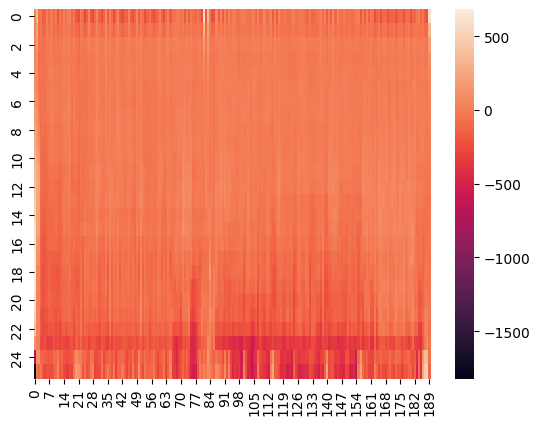

In [141]:
sns.heatmap(dir_across_layers_pos)
plt.show()

In [144]:
pattern_hook_names_filter = lambda name: name.endswith("hook_resid_pre") or name.endswith("25.hook_resid_post") or  name.endswith('ln_final.hook_scale'

)

_,cache = model.run_with_cache(tokens,names_filter = pattern_hook_names_filter)
accum_resid, labels = cache.accumulated_resid(return_labels=True, apply_ln=True)


In [153]:

resid_stack = accum_resid[:-2].to("cpu").detach()
eot_token = model.to_tokens("<end_of_turn>", prepend_bos = False).item()
eot_dir = model.W_U[:,eot_token].to("cpu").detach()
dir_across_layers_pos = einops.einsum(eot_dir, resid_stack,"d_model,n_layers batch pos d_model -> n_layers batch pos" )[:,0]


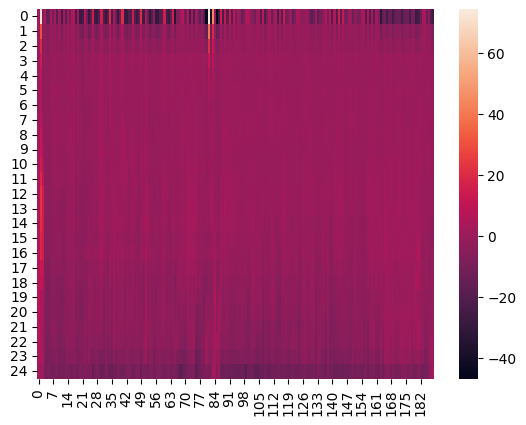

In [159]:
sns.heatmap(dir_across_layers_pos[:,:-1])
plt.show()

In [169]:
w_u = model.W_U.detach().to("cpu")
logit_lens = einops.einsum(w_u, resid_stack[-1,0,-10:,:].detach(),"d_model d_vocab ,pos d_model -> d_vocab pos" )


In [181]:
val, indices = logit_lens.topk(k = 20,dim = 0)
for ind in indices:
    print([model.to_string(t) for t in ind])

['2', '1', ' farm', ' animals', '.', ' total', '.', ' ', '\n', '<eos>']
['3', '2', ' Farm', ' animal', ' in', ' totale', '\n\n', '\n\n', '\n\n', 'ryl']
[' ', '0', ' total', 'animal', ' total', 'total', ' ', '\n', '\n\n\n', '\n\n\n\n']
[' twenty', '7', 'farm', ' Animal', ' together', ' Total', '\n', '  ', '\n\n\n\n', 'стри']
['Twenty', 'CR', '\n\n', ' animais', '\n\n', ' all', ' because', '\n\n\n', '\n\n\n\n\n', '下一']
['1', ' hồn', ' animal', 'Animal', ' ', 'Total', ',', '\n\n\n\n', '  ', 'law']
['Thirty', 'ny', '.', ' animales', ' altogether', ' TOTAL', '!', '   ', '\n\n\n\n\n\n', ' replied']
[' thirty', '3', ' animals', ' and', ',', ' the', ' if', ' The', '\n\n\n\n\n\n\n', 'lamo']
['  ', '呑', '+', ' animale', ' combined', ' addition', ' .', ' Here', '   ', 'ary']
['\n', ' insan', ' in', 'animals', ' on', ' totaal', '..', '\n\n\n\n\n', '<eos>', 'Turkey']
['4', 'жде', ' live', ' Animals', '  ', ' their', '\n\n\n', ' This', ' ', 'lait']
[' Twenty', 'กร', ' of', ' or', '\n', ' sum', ' (',

In [200]:
text = final_text[11].split("<start_of_turn>model")[0]+"<start_of_turn>model"
text

'<bos><start_of_turn>user Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n Did Harry Potter put his own name in the goblet of fire? <end_of_turn>\n<start_of_turn>model'

### Get the generation going

In [243]:
from collections import defaultdict
text = final_text[11].split("<start_of_turn>model")[0]+"<start_of_turn>model"
cache = defaultdict(list)
tokens = model.to_tokens(text,prepend_bos = False)
def caching_hook(activations, hook, pos = None):
    cache[hook.name].append(activations.to("cpu"))
    
with model.hooks(fwd_hooks=[(get_act_name("resid_post",i),caching_hook) for i in range(0,model.cfg.n_layers)]),torch.no_grad():  
        out = model.generate(
            tokens,
            max_new_tokens = 400,
            temperature = 0.7,
            top_p = 0.9,
            eos_token_id=107,
            stop_at_eos=True,
            )

  0%|          | 0/400 [00:00<?, ?it/s]

In [230]:
print(model.to_string(out)[0])

<bos><start_of_turn>user Below is an instruction that describes a task. Write a response that appropriately completes the request.

 Did Harry Potter put his own name in the goblet of fire? <end_of_turn>
<start_of_turn>modelThe answer is **yes, but not in the way you might think.** 

Harry Potter did not put his own name in the Goblet of Fire.  **He was chosen by the Goblet of Fire as a participant in the Triwizard Tournament.** This was a magical event that occurred in the fourth Harry Potter book, and it was a result of a series of events, including a strange and unexplained magical ritual. 

**The implication that Harry put his name in the Goblet of Fire is a common misinterpretation.** It stems from a misunderstanding of the events that led to his selection. 
<end_of_turn><eos>


In [244]:
stacked_cache = torch.cat([torch.cat(val, dim = 1) for val in cache.values()])

In [245]:
eot_token = model.to_tokens("<end_of_turn>", prepend_bos = False).item()
eot_dir = model.W_U[:,eot_token].to("cpu").detach()
dir_across_layers_pos = einops.einsum(eot_dir, stacked_cache,"d_model,n_layers pos d_model -> n_layers pos" )

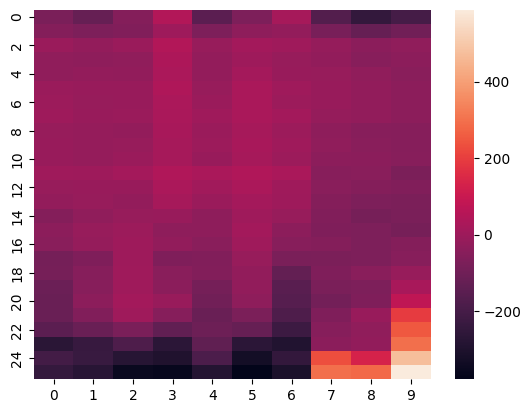

In [249]:
sns.heatmap(dir_across_layers_pos[:,-10:])
plt.show()

### Generate outputs

tensor([ 84,  37,  42,  35,  34,  31,  38, 103,  37,  39, 151,  39, 132, 105,
        152,  57,  88,  40,  45,  52,  35,  36,  39,  63,  41,  31,  34,  36,
         45,  37, 115,  66,  33, 157,  50,  32,  54,  34,  43,  41,  33, 164,
         51,  32,  38,  40,  34,  37,  40,  32,  37, 109,  35, 136, 155,  34,
         40,  42,  36,  33,  53, 156, 172,  42,  42,  40,  34,  32,  40,  51,
         68,  34,  35, 141,  32,  32,  33,  31,  33,  41,  46,  47,  33,  40,
         50,  34,  40,  73,  58,  36,  36,  31,  35,  61,  33,  37,  92,  36,
         37,  41,  95,  32,  33, 113,  36,  32,  31,  34,  33,  39,  72,  36,
        159,  41,  38,  31,  31,  32,  35,  38,  45,  43,  35,  49,  42,  38,
        105,  36,  44,  39,  35,  37,  32,  42,  46, 112,  37,  40,  60,  40,
         30,  36,  36, 125, 178,  33,  34,  40, 100,  35,  30,  37,  38,  31,
         34,  61,  36,  38,  40,  40,  52,  35,  31,  40,  87, 118,  39,  44,
         37,  41,  41, 156,  84,  42,  31,  45,  33,  40,  56,  

In [ ]:
final_text = text_array[samp_ind].tolist()
def caching_hook(activations, hook, pos = None):
    cache[hook.name].append(activations.to("cpu"))
for i,text in enumerate(final_text):
    cache = defaultdict(list)
    pos = starts_model_turn_pos[i] 
    tokens = model.to_tokens(text,prepend_bos = False)
    


In [251]:

    
with model.hooks(fwd_hooks=[(get_act_name("resid_post",i),caching_hook) for i in range(0,model.cfg.n_layers)]),torch.no_grad():  
        out = model.generate(
            tokens,
            max_new_tokens = 400,
            temperature = 0.7,
            top_p = 0.9,
            eos_token_id=107,
            stop_at_eos=True,
            )

'\n'